In [1]:
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import unfolding_network
import data_generation
import constants

import sys
sys.path.append(constants.HOME_DIR)
sys.path.append('/FRUIT')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
%matplotlib inline

In [2]:
xeval, yeval = None, None
xother, yother = None, None

def shuffle_test_data():
    global xeval, yeval, xother, yother
    x,y = data_generation.x_data_IAEA, data_generation.y_data_IAEA
    boot = ShuffleSplit(n_splits = 1, test_size = 0.5)
    for other, test in boot.split(x):
        xeval, yeval = x[test], y[test]
        xother, yother = x[other], y[other]
        return

shuffle_test_data()

In [3]:
trials = 1

def evaluate(args):
    algorithm, params = args
    
    benchmark = []
    models = []
    
    data_points = 2000
    xdata, ydata = algorithm(data_points, yother)
    
    boot = ShuffleSplit(n_splits = trials, test_size = 0.25)
    trial = 0
    for train, test in boot.split(xdata):
        
        trial += 1
        
        xtrain, ytrain = xdata[train], ydata[train]
        xtest, ytest = xdata[test], ydata[test]
        
        print("Starting {} ...".format(trial))
        
        model = unfolding_network.generate_model(**params)
        
        model.compile(loss = "mse", optimizer = Adam(learning_rate=0.001))
        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10,
                                patience=200, verbose=0, mode='min',
                                restore_best_weights=True)
        
        model.fit(xtrain,ytrain,validation_data=(xtest,ytest),
                  callbacks=[monitor],verbose=0,epochs=100000,
                  batch_size=int(constants.OPT_PARAMS_UNFOLD["batch_size"]))
        
        pred = model.predict(xeval)
        
        score = metrics.mean_squared_error(yeval, pred)
        
        benchmark.append(score)
        
        models.append(model)
    
    return np.mean(benchmark), np.std(benchmark), models
    
    
    

In [4]:
PSA = data_generation.PSA
GAN = data_generation.GAN
RAND = data_generation.RAND
GAUSS = data_generation.GAUSS
FRUIT = data_generation.FRUIT

In [7]:
x,y = GAUSS(100, [])

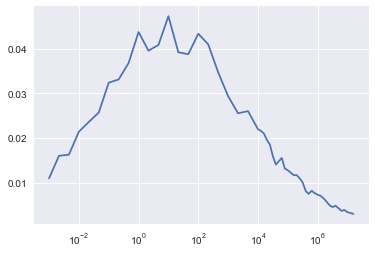

In [11]:
plt.plot(constants.Ebins, y[2])
plt.xscale("log")

In [5]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(5)

results = pool.map(evaluate, [(PSA, constants.OPT_PARAMS_UNFOLD), 
                              (GAN, constants.OPT_PARAMS_UNFOLD_GAN), 
                              (RAND, constants.OPT_PARAMS_UNFOLD_RAND), 
                              (GAUSS, constants.OPT_PARAMS_UNFOLD_GAUSS),
                              (FRUIT, constants.OPT_PARAMS_UNFOLD_FRUIT)])

Metal device set to: Apple M1
Starting 1 ...
Starting 1 ...
Starting 1 ...
Starting 1 ...
Starting 1 ...


In [6]:
meanPSA, stdPSA, modelsPSA = results[0]
meanGAN, stdGAN, modelsGAN = results[1]
meanRAND, stdRAND, modelsRAND = results[2]
meanGAUSS, stdGAUSS, modelsGAUSS = results[3]
meanFRUIT, stdFRUIT, modelsFRUIT = results[4]

In [7]:
print("PSA: {:e}".format(meanPSA))
print("FRUIT: {:e}".format(meanFRUIT))
print("RAND: {:e}".format(meanRAND))
print("GAN: {:e}".format(meanGAN))
print("GAUSS: {:e}".format(meanGAUSS))

PSA: 1.260601e-04
FRUIT: 1.791231e-04
RAND: 4.110190e-04
GAN: 7.046313e-04
GAUSS: 1.149332e-03


In [18]:
x,y = data_generation.loadXY()
#np.random.shuffle(x)
#np.random.shuffle(y)

In [29]:
# 0 is example of good fitting
# 10 also

# 170 shows disagreement between pseudo-inverse, where ML does better

k = 170

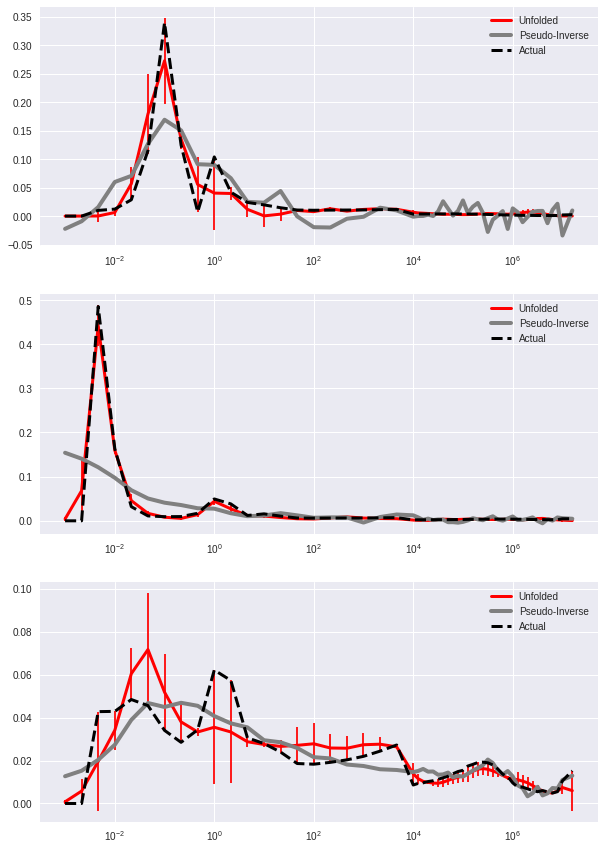

In [30]:
models = modelsPSA

fig, axs = plt.subplots(3, 1, figsize = (10, 15))

i = k
for row in axs:
        
    spectra = np.zeros(len(constants.Ebins))
    dev = np.zeros(len(constants.Ebins))
    for model in models:
        spectra += model(x)[i]
        dev += (model(x)[i] - y[i])**2
    spectra = spectra / trials
    dev = np.sqrt(dev / trials)
    row.plot(constants.Ebins, spectra, label = "Unfolded", color = "red", linewidth = 3)
    row.errorbar(constants.Ebins, spectra, yerr=dev, linestyle = "", color = "red")
    row.set_xscale("log")
    
    row.plot(constants.Ebins, np.matmul(np.linalg.pinv(constants.cm), x[i]), label = "Pseudo-Inverse", color = "grey", linewidth = 4)
    
    row.plot(constants.Ebins, y[i], label = "Actual", color = "black", linestyle = "dashed", linewidth = 3)
    
    row.legend()
    
    i += 1
